# Reprogramming dataset (static barcoding)

The reprogramming dataset from *Biddy, B. A. et al. Nature 564, 219–224 (2018)*. This dataset has multiple time points for both the clones and the state measurements. 

The cells are barcoded over 3 rounds during the entire differentiation process. 
We combine up to 3 tags from the same cell into a single clonal label in 
representing the X_clone matrix. In this representation, each cell has at most 
one clonal label. Effectively, we convert the barcodes into static labels that do not carry temporal information.

**Key components**: 
    
* Part I: Infer transition map using clones from all time points
    
* Part II: Infer transition map using clones from the last time point
    
* Part III: Infer transition map from state information alone

In [1]:
import cospar as cs

In [2]:
cs.logging.print_version()
cs.settings.verbosity=3
cs.settings.set_figure_params(format='png',dpi=75,fontsize=14) # use png to reduce file size. 

cs.settings.data_path='CellTag_data_1' # A relative path to save data. If not existed before, create a new one.
cs.settings.figure_path='CellTag_figure_1' # A relative path to save figures. If not existed before, create a new one.

Running cospar 0.0.7 (python 3.6.12) on 2021-02-09 17:52.


## Loading data

In [3]:
adata_orig=cs.datasets.reprogramming_merge_tags()

  0%|          | 0.00/149M [00:00<?, ?B/s]

creating directory CellTag_data_1/ for saving data
creating directory CellTag_figure_1/ for saving figures
try downloading from url
https://kleintools.hms.harvard.edu/tools/downloads/cospar/CellTagging_ConcatenateClone_adata_preprocessed.h5ad
... this may take a while but only happens once


100%|██████████| 149M/149M [00:02<00:00, 61.3MB/s] 


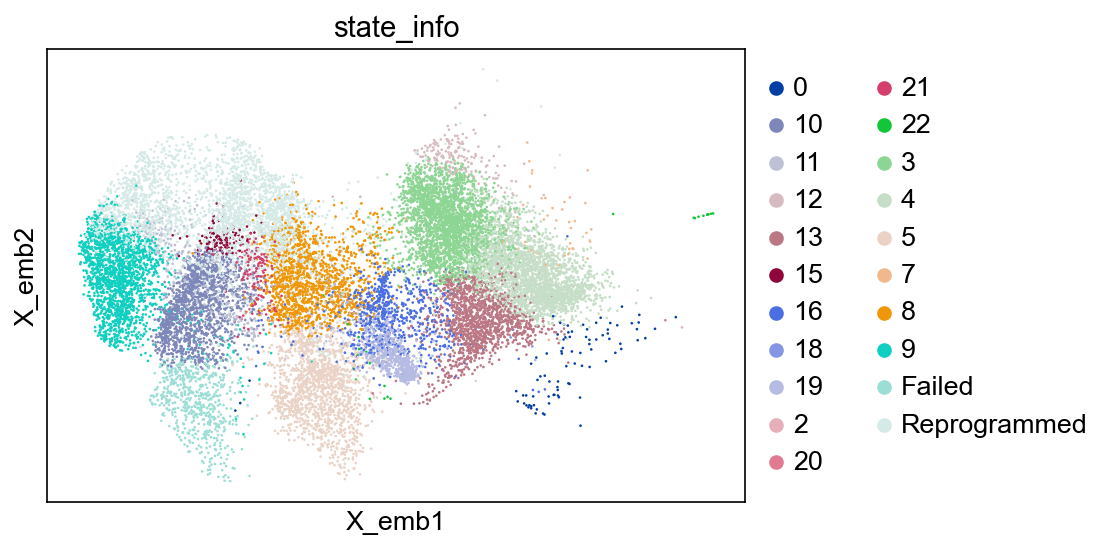

In [4]:
cs.pl.embedding(adata_orig,color='state_info')

In [5]:
cs.hf.check_available_choices(adata_orig)

Available transition maps: []
Availabel clusters: ['12', '8', '21', 'Failed', '4', '2', '15', '13', '18', '10', '9', '11', '3', '0', '5', '20', '16', '7', '19', '22', 'Reprogrammed']
Availabel time points: ['4', '3', '8', '5', '6', '7']
Clonal time points: ['4', '3', '8', '5', '6', '7']


In [6]:
re_propressing=False
if re_propressing:
    cs.pp.get_highly_variable_genes(adata_orig)
    cs.pp.remove_cell_cycle_correlated_genes(adata_orig,corr_threshold=0.03,confirm_change=True)
    cs.pp.get_X_pca(adata_orig,n_pca_comp=40)
    cs.pp.get_X_emb(adata_orig,n_neighbors=20,umap_min_dist=0.3)
    #cs.pp.get_state_info(adata_orig,n_neighbors=20,resolution=0.5) # if this is changed, the cluster name used later will be wrong.
    cs.pl.embedding(adata_orig,color='time_info')

### Raw clonal data analysis

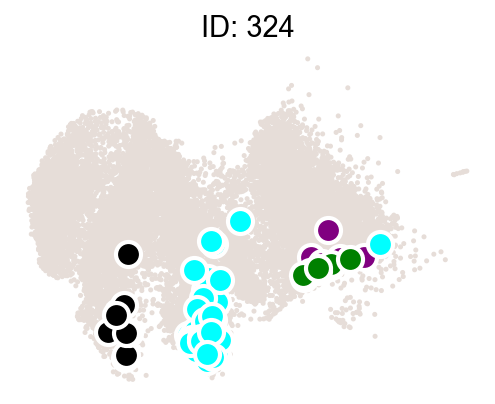

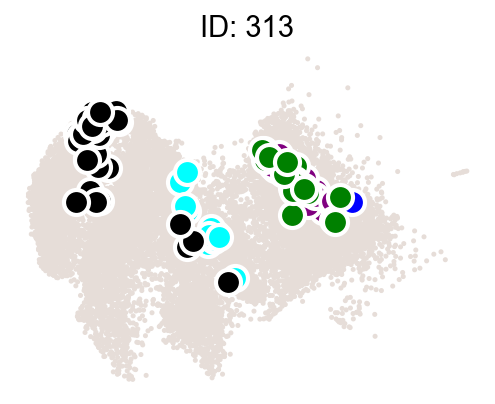

In [7]:
#cs.pl.clones_on_manifold(adata_orig,selected_clone_list=[1],color_list=['black','red','blue'],point_size=2)
cs.pl.clones_on_manifold(adata_orig,selected_clone_list=[324,313],point_size=2) #324,313,446,716,367


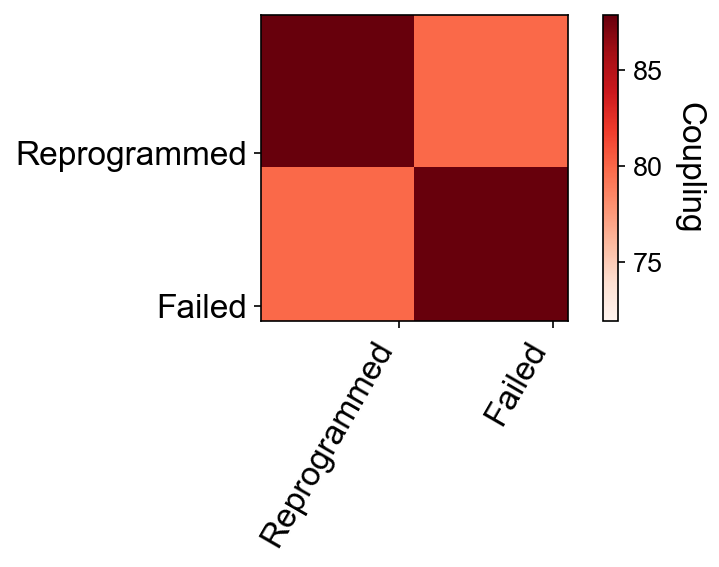

In [8]:
selected_time_point='8'
selected_fates=['Reprogrammed','Failed']
cs.pl.fate_coupling_from_clones(adata_orig,selected_time_point, selected_fates=selected_fates, color_bar=True)

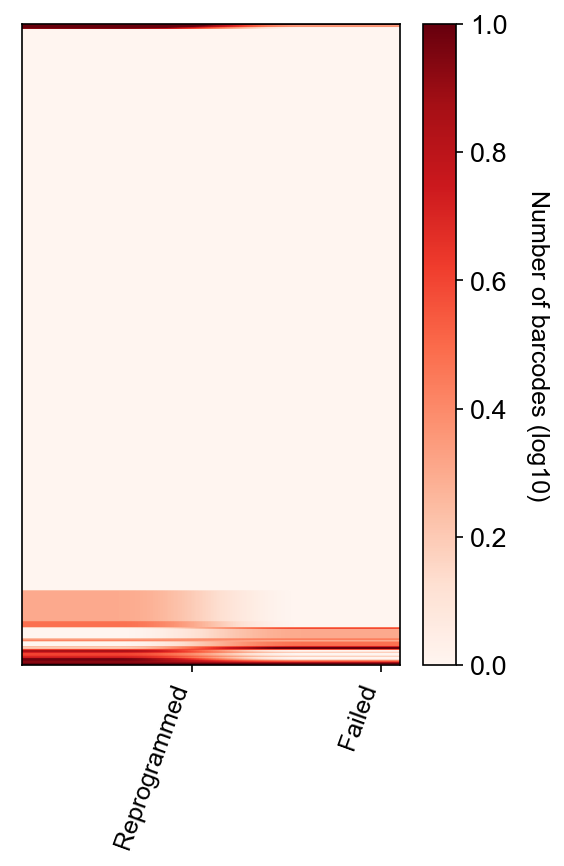

In [9]:
selected_time_point='8'
cs.pl.barcode_heatmap(adata_orig,selected_time_point, selected_fates=selected_fates, color_bar=True)

Current clone id: 0
Current clone id: 50
Current clone id: 100
Current clone id: 150
Current clone id: 200
Current clone id: 250
Current clone id: 300
Current clone id: 350
Current clone id: 400
Current clone id: 450
Current clone id: 500
Current clone id: 550
Current clone id: 600
Current clone id: 650
Current clone id: 700
Current clone id: 750
Current clone id: 800
Current clone id: 850
Current clone id: 900
Current clone id: 950
Current clone id: 1000
Current clone id: 1050


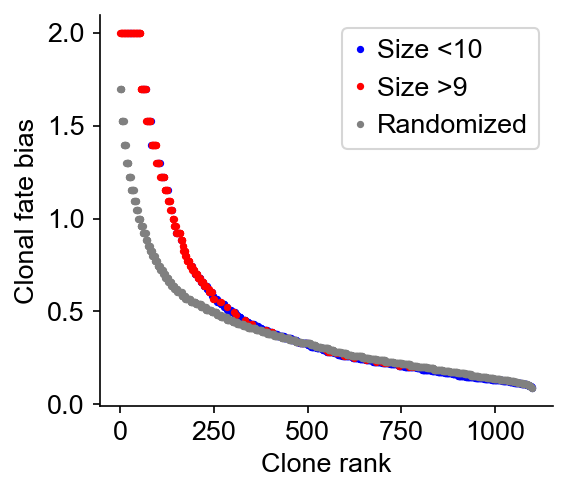

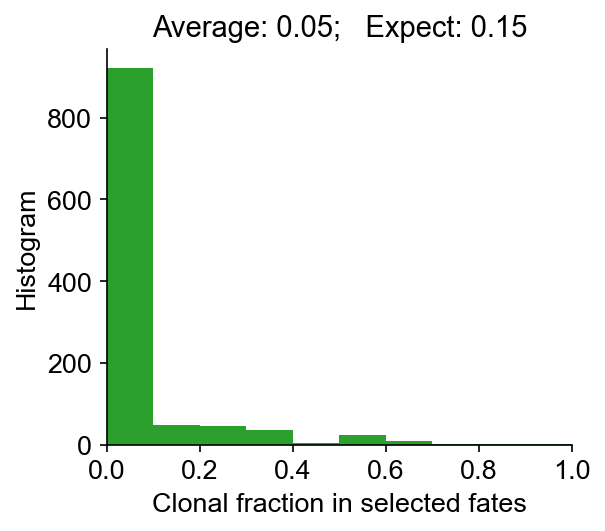

In [10]:
clonal_fate_bias,clone_id=cs.pl.clonal_fate_bias(adata_orig,selected_fate='Reprogrammed',
    clone_size_thresh=10,N_resampling=100,compute_new=False)

## Part I: Infer transition map using clones from all time points

### Map inference

Running it the first time takes 20 mins, 17 mins of which are used to compute the similarity matrix. When it is run again, it only takes 3 mins.

-------Step 1: Select time points---------
--> Clonal cell fraction (day 3-4): 0.47126436781609193
--> Clonal cell fraction (day 4-5): 0.7685492801771872
--> Clonal cell fraction (day 5-6): 0.7980198019801981
--> Clonal cell fraction (day 6-7): 0.805352798053528
--> Clonal cell fraction (day 7-8): 0.8049918831168831
--> Clonal cell fraction (day 4-3): 0.07308970099667775
--> Clonal cell fraction (day 5-4): 0.6072607260726073
--> Clonal cell fraction (day 6-5): 0.8746958637469586
--> Clonal cell fraction (day 7-6): 0.8952922077922078
--> Clonal cell fraction (day 8-7): 0.9663468859448759
--> Numer of cells that are clonally related -- day 3: 41  and day 4: 66
--> Numer of cells that are clonally related -- day 4: 694  and day 5: 1840
--> Numer of cells that are clonally related -- day 5: 2418  and day 6: 2876
--> Numer of cells that are clonally related -- day 6: 2648  and day 7: 4412
--> Numer of cells that are clonally related -- day 7: 3967  and day 8: 6346
Valid clone number 'FOR' p

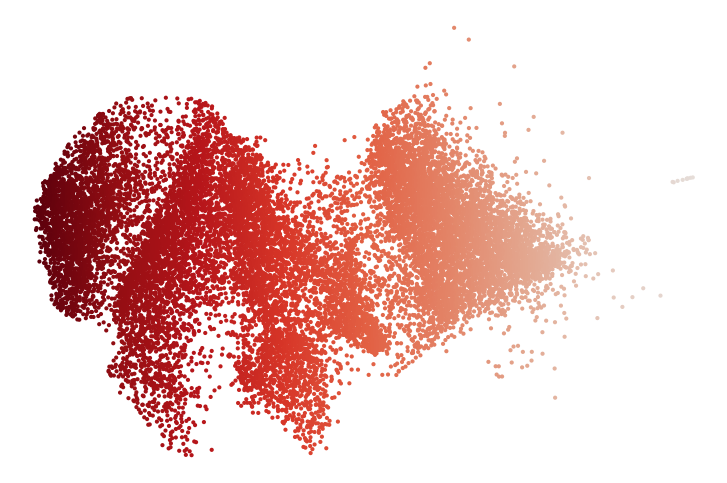

In [11]:
noise_threshold=0.2 # 
selected_clonal_time_points=['3','4','5','6','7','8']
#selected_clonal_time_points=['7','8']
adata=cs.tmap.infer_Tmap_from_multitime_clones(adata_orig,selected_clonal_time_points,smooth_array=[15,10,5],
        noise_threshold=noise_threshold,demulti_threshold=noise_threshold,use_full_Smatrix=True)

### Save or load pre-computed data

This can be used to save adata with maps computed from different tools or parameters.
Usually, different parameter choices will result in different `data_des`, a prefix to identify the anndata.
Saving an adata would print the `data_des`, which can be used to load the corresponding adata.

In [12]:
save_data=False
if save_data:
    cs.hf.save_map(adata)
    
load_data=False
if load_data:
    ## Updated Jan 28, 2021
    #data_des='CellTagging_TwoTimeClone_t*3*4*5*6*7*8'
    data_des='CellTagging_OneTimeClone_t*3*4*5*6*7*8'
    adata=cs.hf.load_saved_adata_with_key(data_des)


Saved file: data_des='CellTagging_MultiTimeClone_0_t*3*4*5*6*7*8'


In [13]:
cs.hf.check_available_choices(adata)

Available transition maps: ['transition_map', 'intraclone_transition_map']
Availabel clusters: ['12', '8', '21', 'Failed', '4', '2', '15', '13', '18', '10', '9', '11', '3', '0', '5', '20', '16', '7', '19', '22', 'Reprogrammed']
Availabel time points: ['4', '3', '8', '5', '6', '7']
Clonal time points: ['4', '3', '8', '5', '6', '7']


## Plotting

There are some common parameters:

* `used_map_name` (str). Determines which transition map to use for analysis. Choices: {‘transition_map’, ‘intraclone_transition_map’, ‘OT_transition_map’, ‘HighVar_transition_map’,’clonal_transition_map’}

* `selected_fates` (list of str). Selected clusters to aggregate differentiation dynamics and visualize fate bias etc.. The selected_fates allows nested structure, e.g., selected_fates=[‘1’, [‘0’, ‘2’]] selects two clusters: cluster ‘1’ and the other that combines ‘0’ and ‘2’.

* `map_backwards` (bool). We can analyze either the forward transitions, i.e., where the selected states or clusters are going (map_backwards=False), or the backward transitions, i.e., where these selected states or clusters came from (map_backwards=False). The latter is more useful, and is the default.

* `selected_time_points` (list). List of time points to use. By default, all are used. 

### Plotting transition profiles for single cells

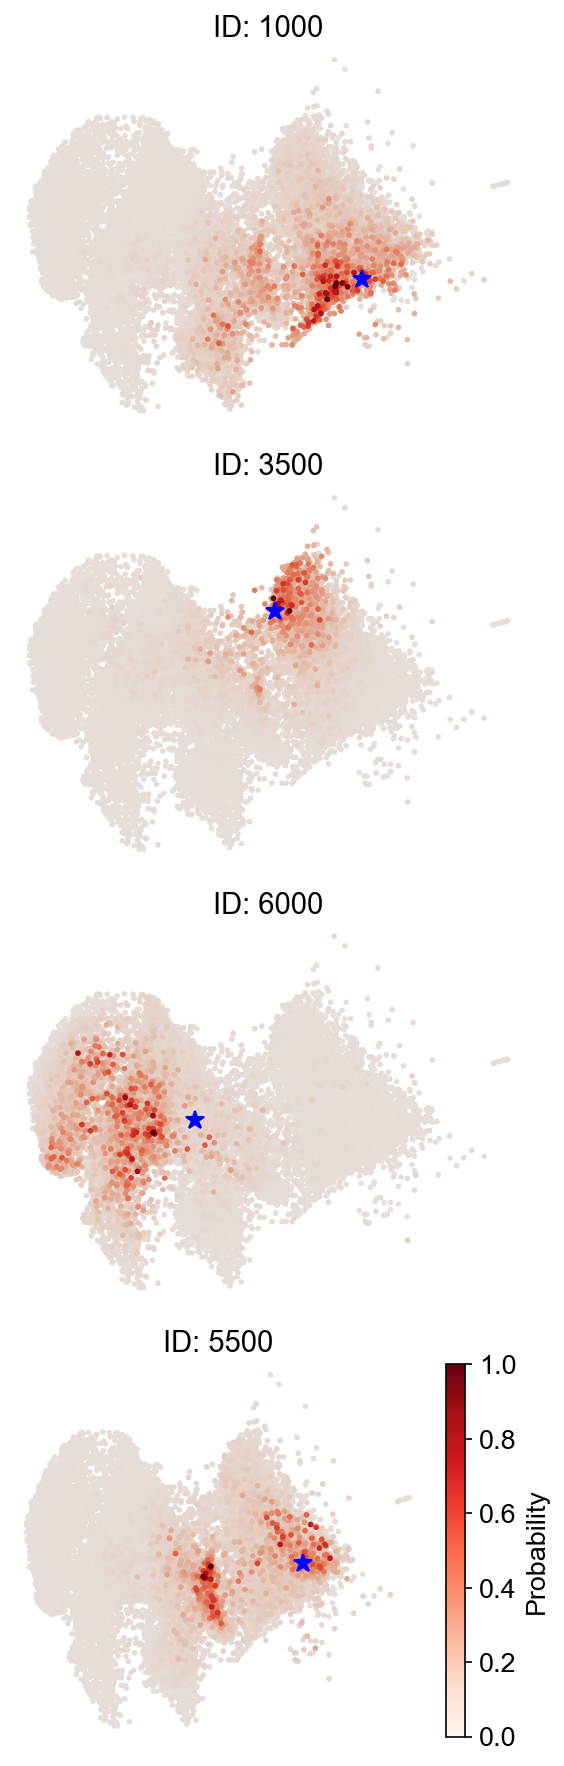

In [14]:
selected_state_id_list=[1000,3500,6000,5500]

cs.pl.single_cell_transition(adata,selected_state_id_list=selected_state_id_list,
                                    used_map_name='transition_map',map_backwards=False)

#### Fate map

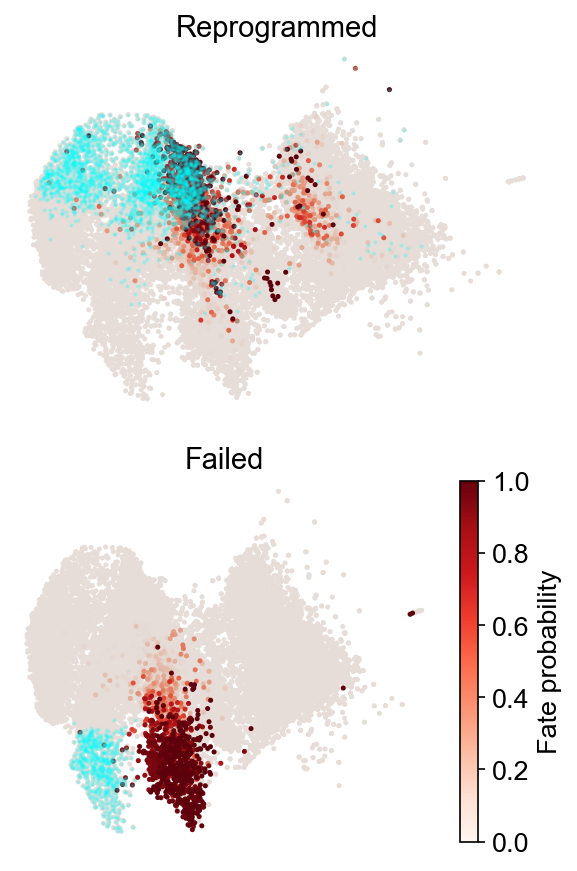

In [15]:
cs.pl.fate_map(adata,selected_fates=['Reprogrammed','Failed'],
               used_map_name='intraclone_transition_map',map_backwards=True,plot_target_state=True)

#### Relative fate bias

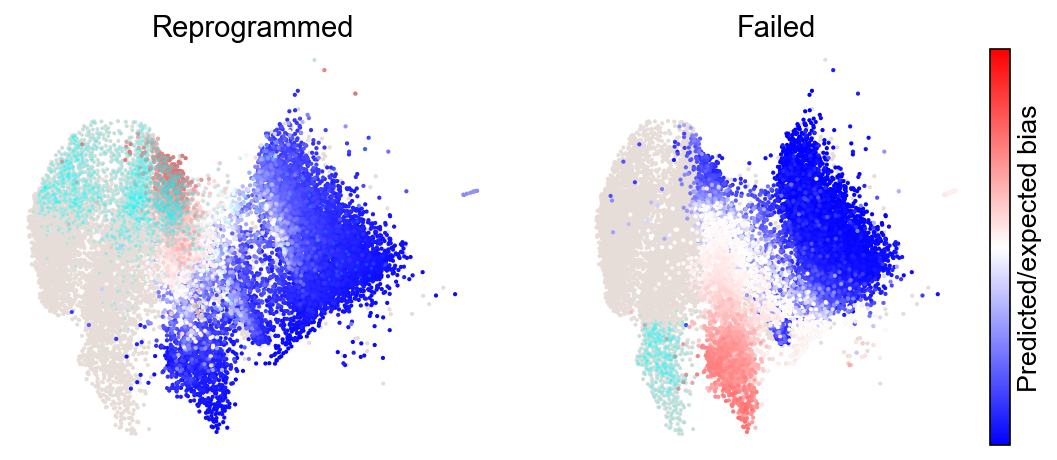

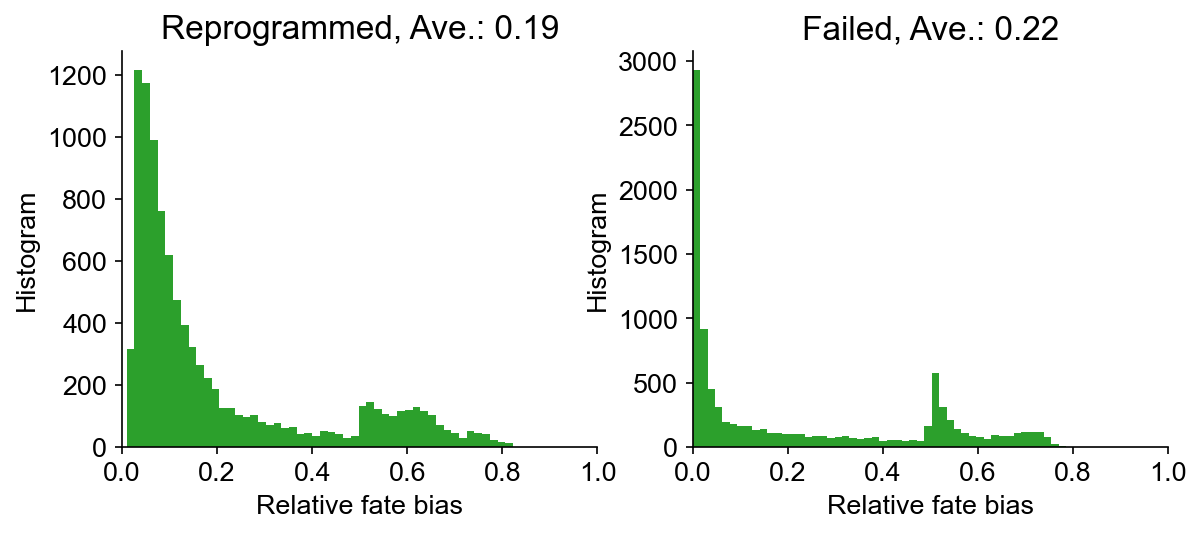

In [16]:
cs.pl.fate_bias_intrinsic(adata,selected_fates=['Reprogrammed','Failed'],used_map_name='transition_map',
            selected_time_points=[],plot_target_state=True,map_backwards=True)

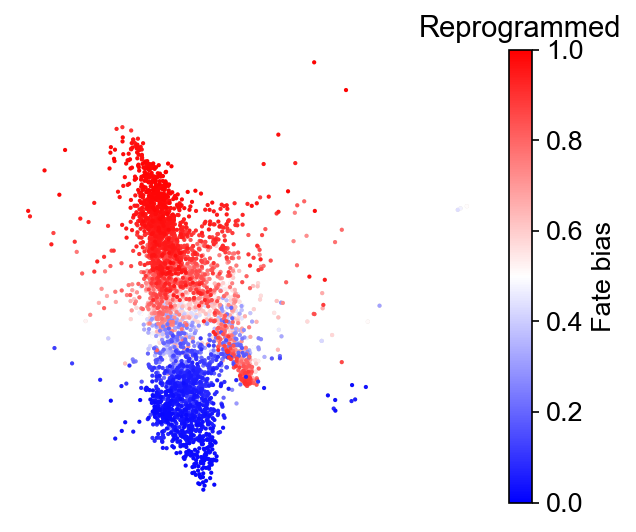

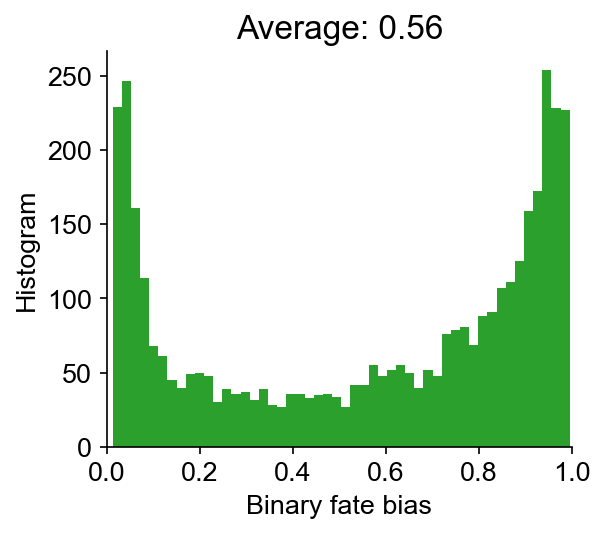

In [17]:
cs.pl.fate_bias_from_binary_competition(adata,selected_fates=['Reprogrammed','Failed'],used_map_name='transition_map',
            selected_time_points=['7'],plot_target_state=False,map_backwards=True,sum_fate_prob_thresh=0)

#### Identify differentially expressed genes

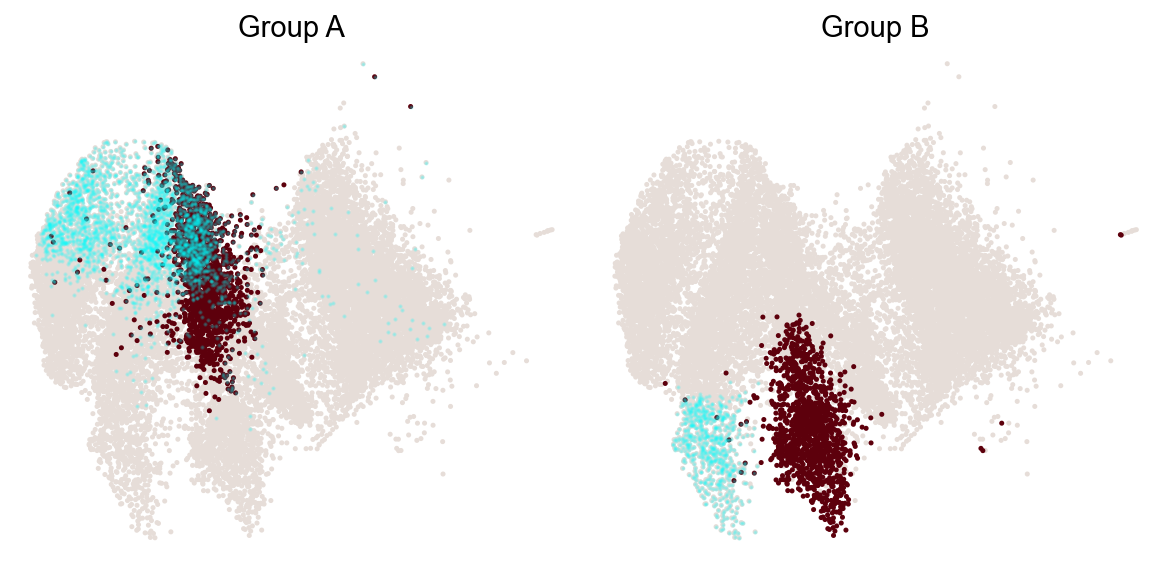

In [18]:
cs.pl.dynamic_trajectory_from_competition_bias(adata, selected_fates=['Reprogrammed','Failed'], 
 used_map_name='transition_map', map_backwards=True, selected_time_points=[],
    bias_threshold=0, sum_fate_prob_thresh=0.2, avoid_target_states=False)


#### Differential genes for two ancestor groups

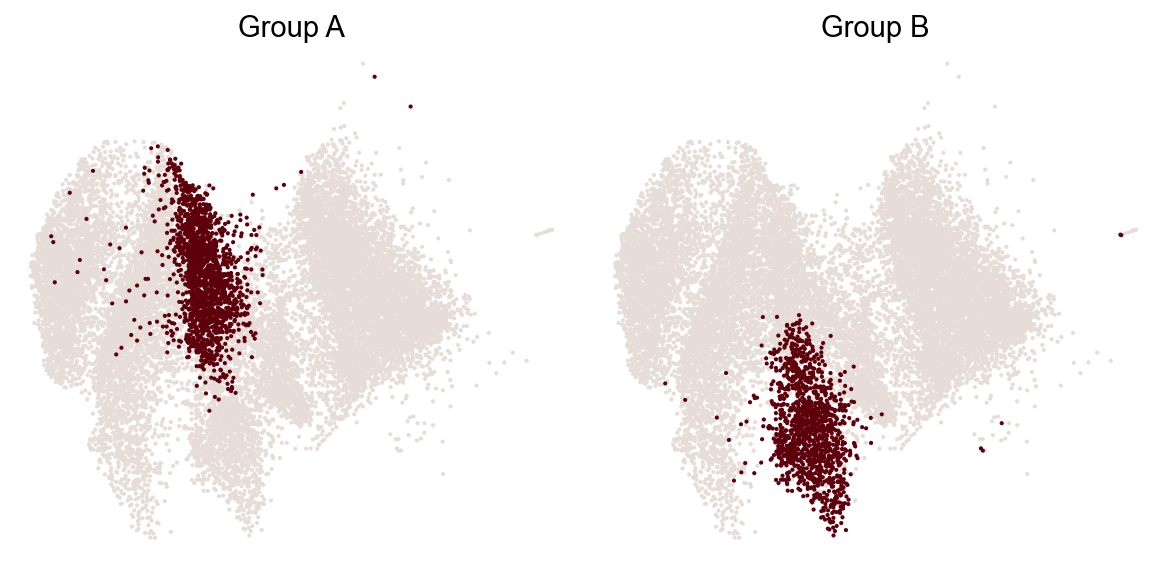

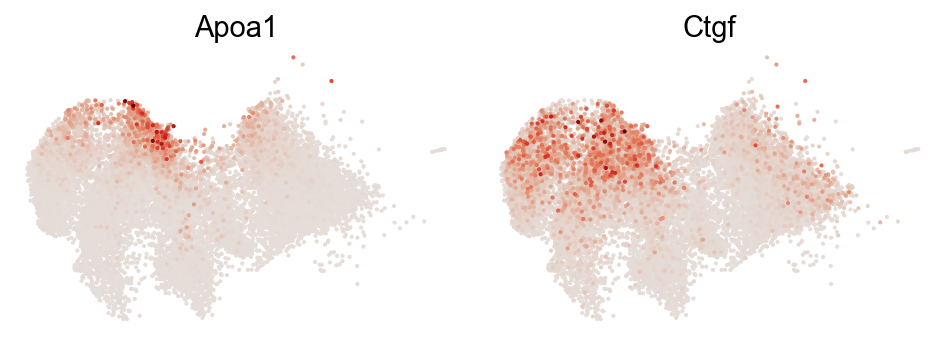

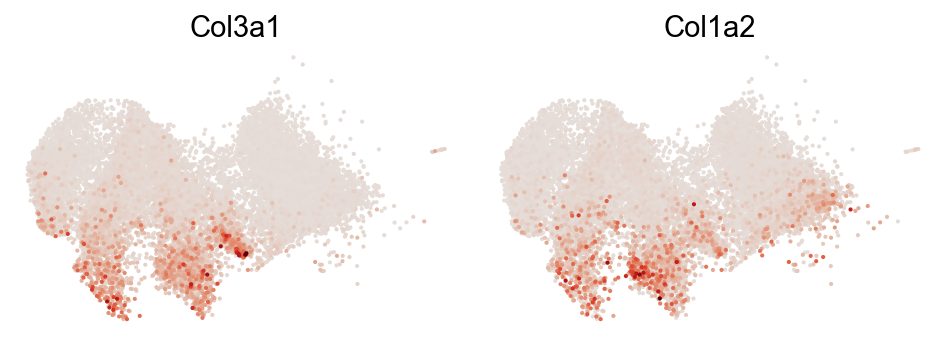

In [19]:
dge_gene_A, dge_gene_B=cs.pl.differential_genes(adata,plot_gene_N=2)

In [20]:
# All, ranked, DGE genes for group A
dge_gene_A

gene             pv    mean_1      mean_2     ratio
13      Apoa1  1.241008e-236  5.935448  122.250092 -4.151456
29       Ctgf  3.206196e-172  0.842752    6.696783 -2.062394
514      Kng1   2.316860e-24  0.896549    5.841588 -1.850955
45    S100a13  4.081427e-141  1.647732    7.533987 -1.688463
3       Timp3  1.010615e-280  5.528621   19.458536 -1.647853
..        ...            ...       ...         ...       ...
504  Atp6v1c2   6.827706e-25  0.055107    0.573739 -0.576807
206     Tpd52   9.228796e-55  0.489315    1.214849 -0.572560
304     Plpp2   2.058986e-40  0.354169    1.012374 -0.571490
357     Mmp15   4.147026e-35  0.064981    0.580205 -0.569284
331     Crim1   7.321637e-38  0.782798    1.643980 -0.568568

[100 rows x 5 columns]

#### Map trajectory backwards iteratively

From our experience, it is better to use the intra-clone transition map to compute the trajectory 

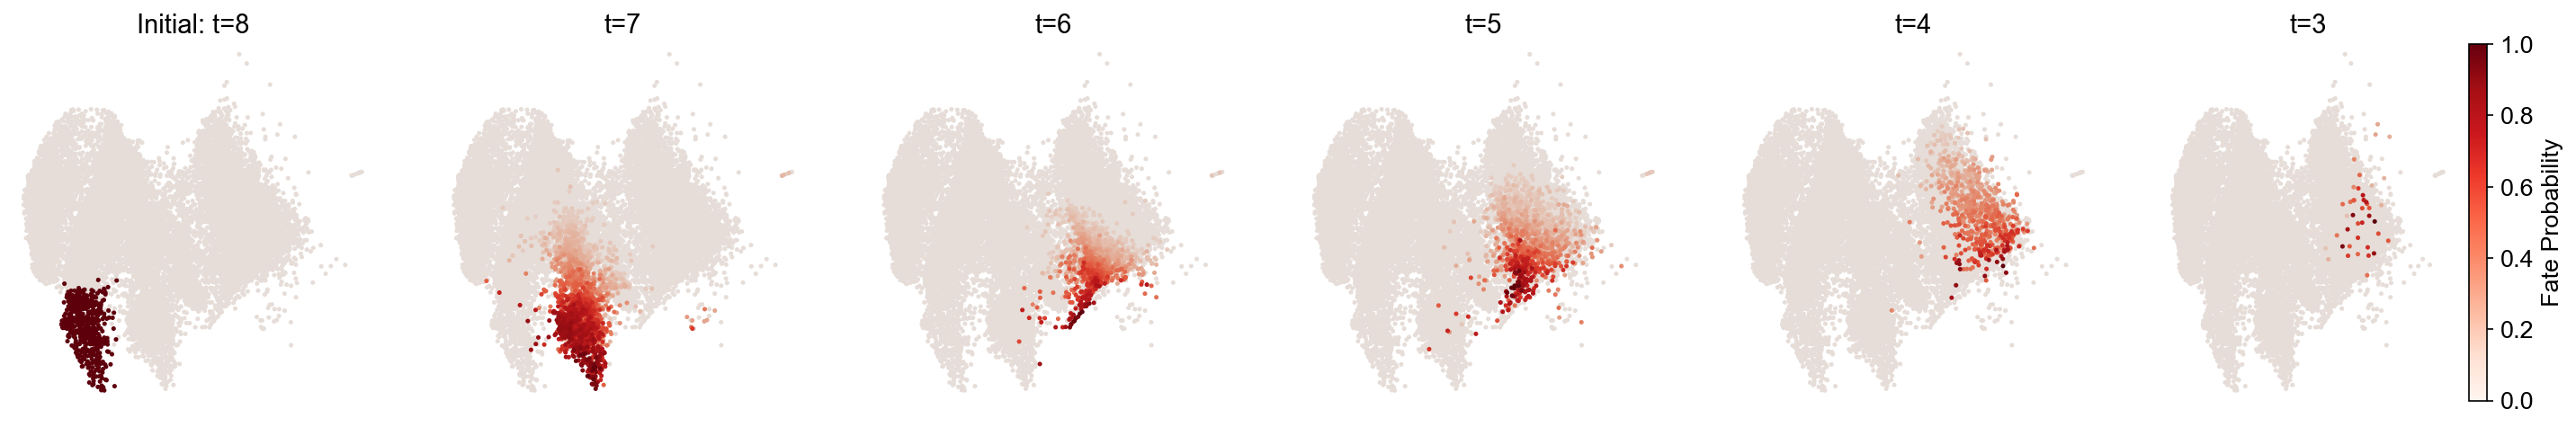

In [21]:
# plot each tiem point separately, use the transition map. 

cs.pl.dynamic_trajectory_via_iterative_mapping(adata,selected_fate='Failed',used_map_name='transition_map',
    map_backwards=True, map_threshold=0.1, plot_separately=True, apply_time_constaint=True, point_size=2)

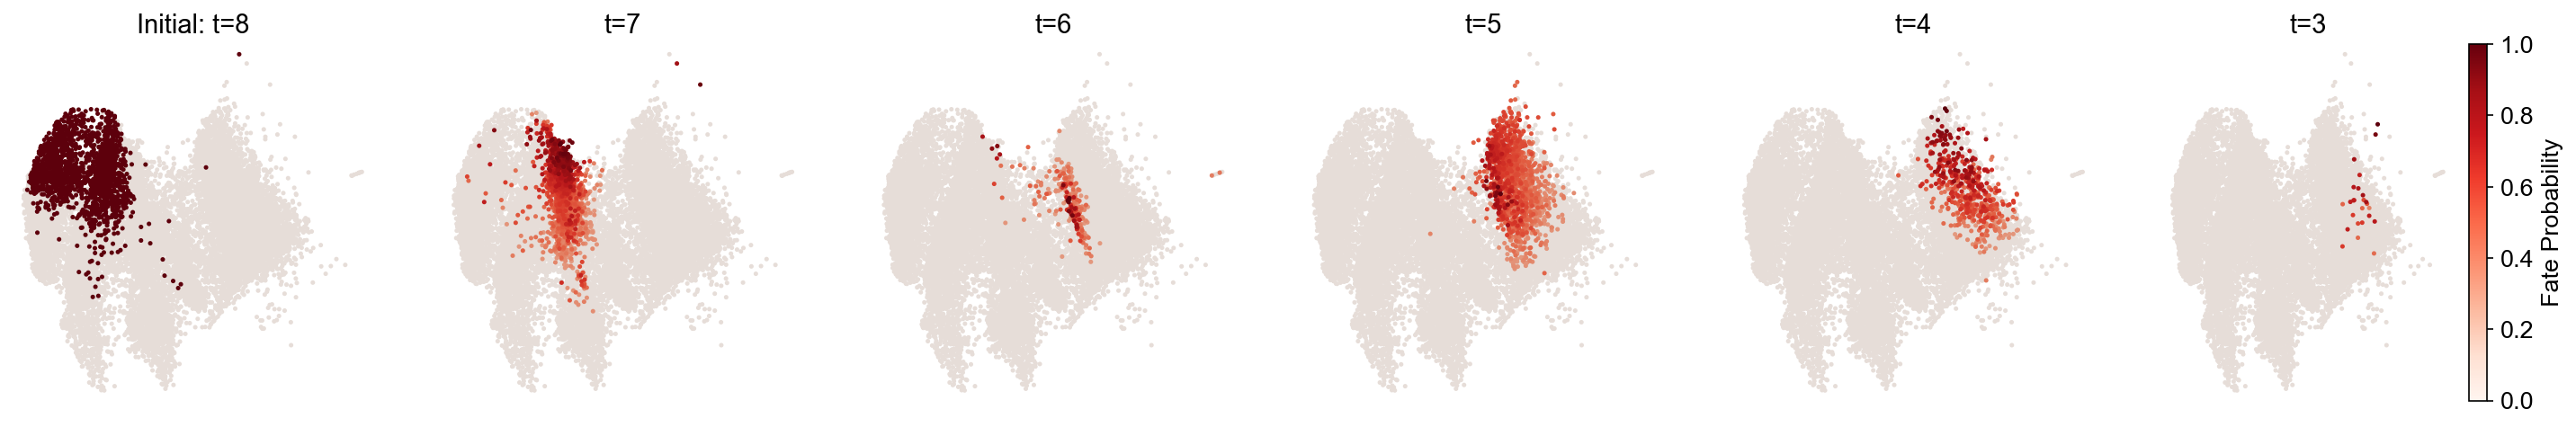

In [22]:
# plot each tiem point separately, use the transition map. 

cs.pl.dynamic_trajectory_via_iterative_mapping(adata,selected_fate='Reprogrammed',used_map_name='transition_map',
    map_backwards=True, map_threshold=0.3, plot_separately=True, apply_time_constaint=True, point_size=2)

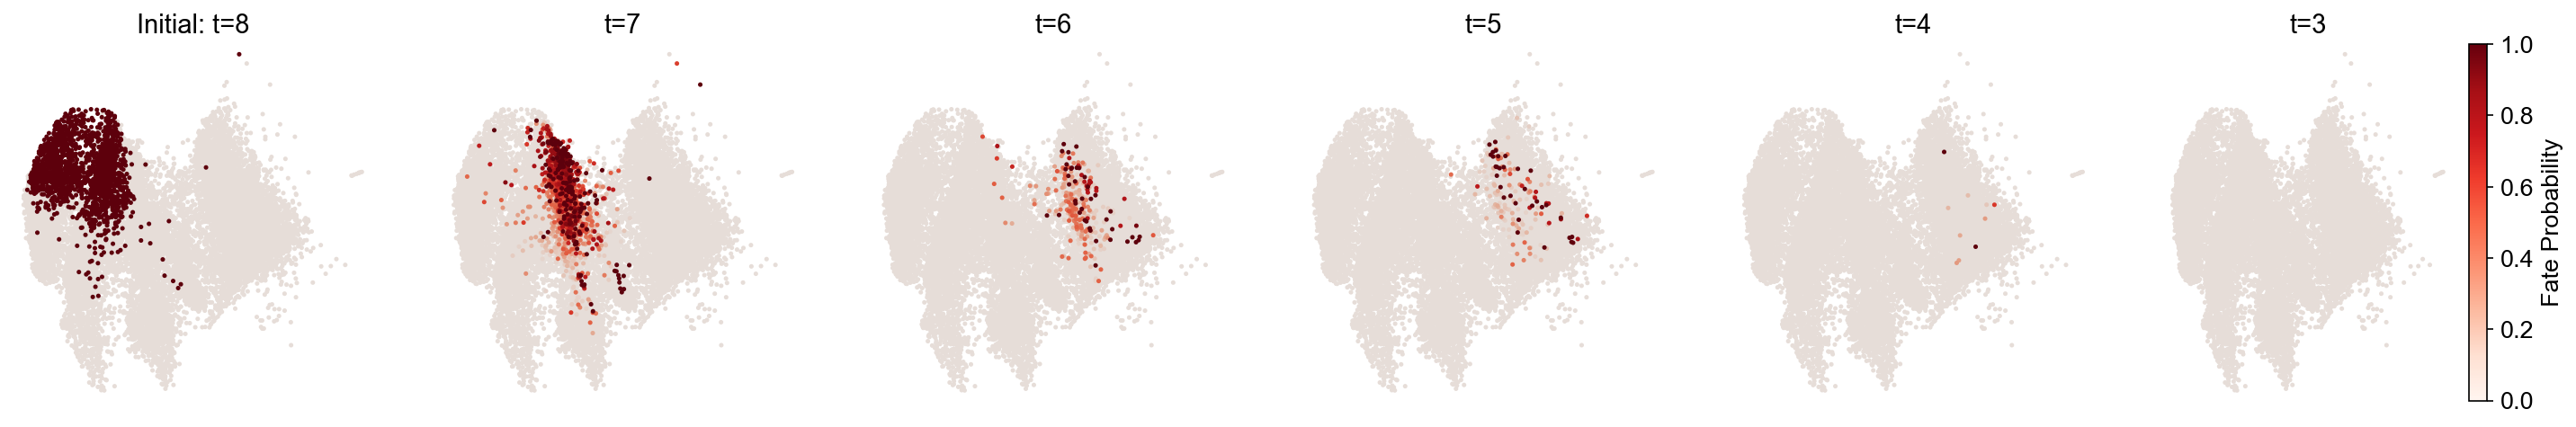

In [23]:
# plot each tiem point separately, use the intra-clone transition map. 
cs.pl.dynamic_trajectory_via_iterative_mapping(adata,selected_fate='Reprogrammed',
                        used_map_name='intraclone_transition_map',
    map_backwards=True, map_threshold=0.05, plot_separately=True, apply_time_constaint=True, point_size=2)

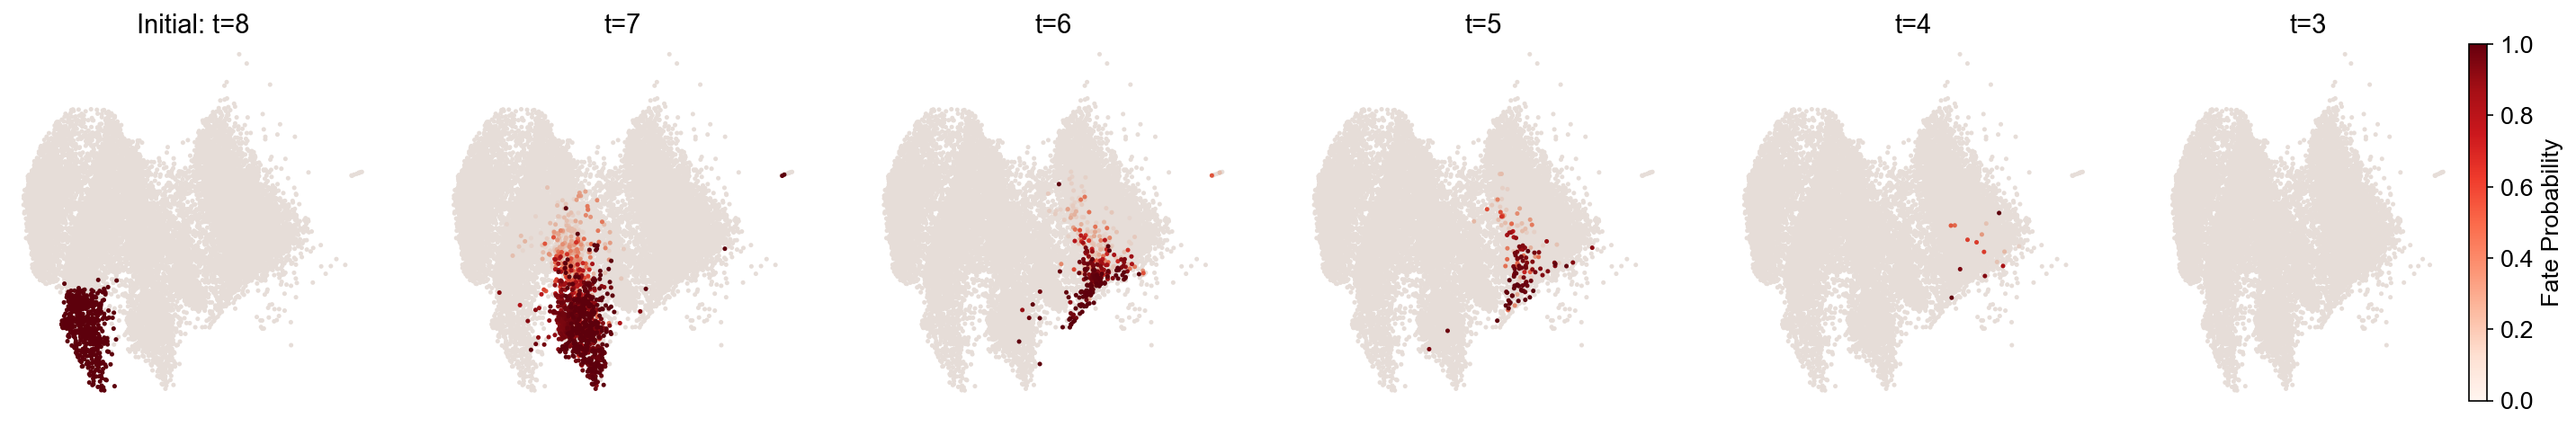

In [24]:
# plot each tiem point separately, use the intra-clone transition map. 
cs.pl.dynamic_trajectory_via_iterative_mapping(adata,selected_fate='Failed',
                        used_map_name='intraclone_transition_map',
    map_backwards=True, map_threshold=0.05, plot_separately=True, apply_time_constaint=True, point_size=2)

#### Gene trend along the trajectory

The results are based on pre-computed dynamic trajectories from the preceding step. It is
better to use the `intraclone_transition_map`. First, show the expression dynamics along the failed trajectory:

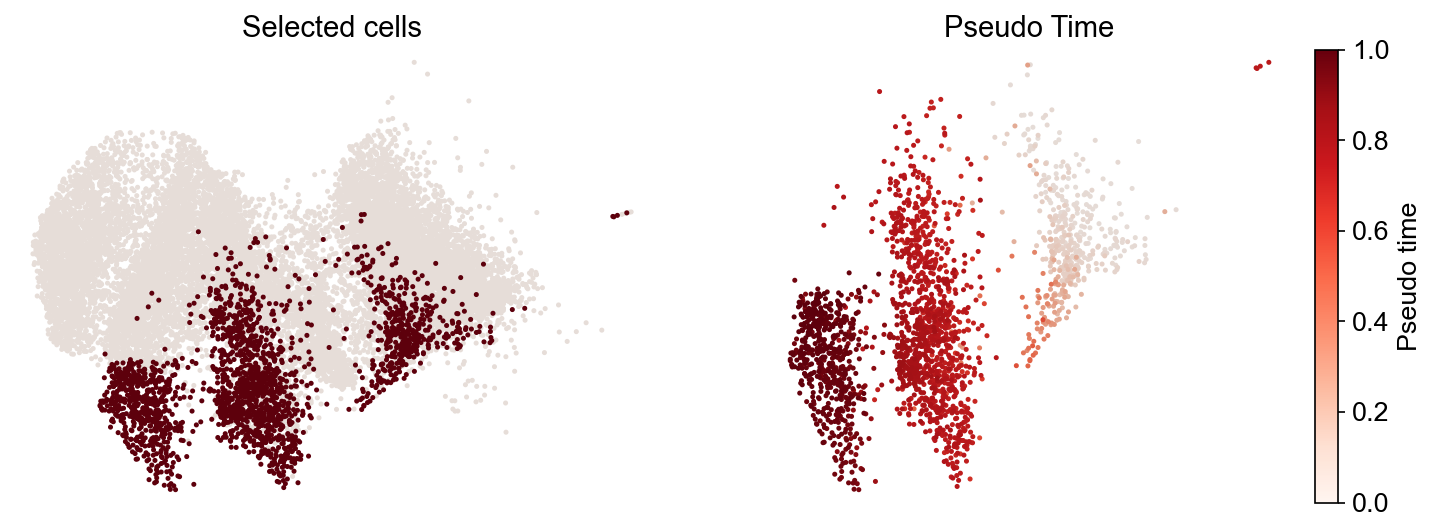

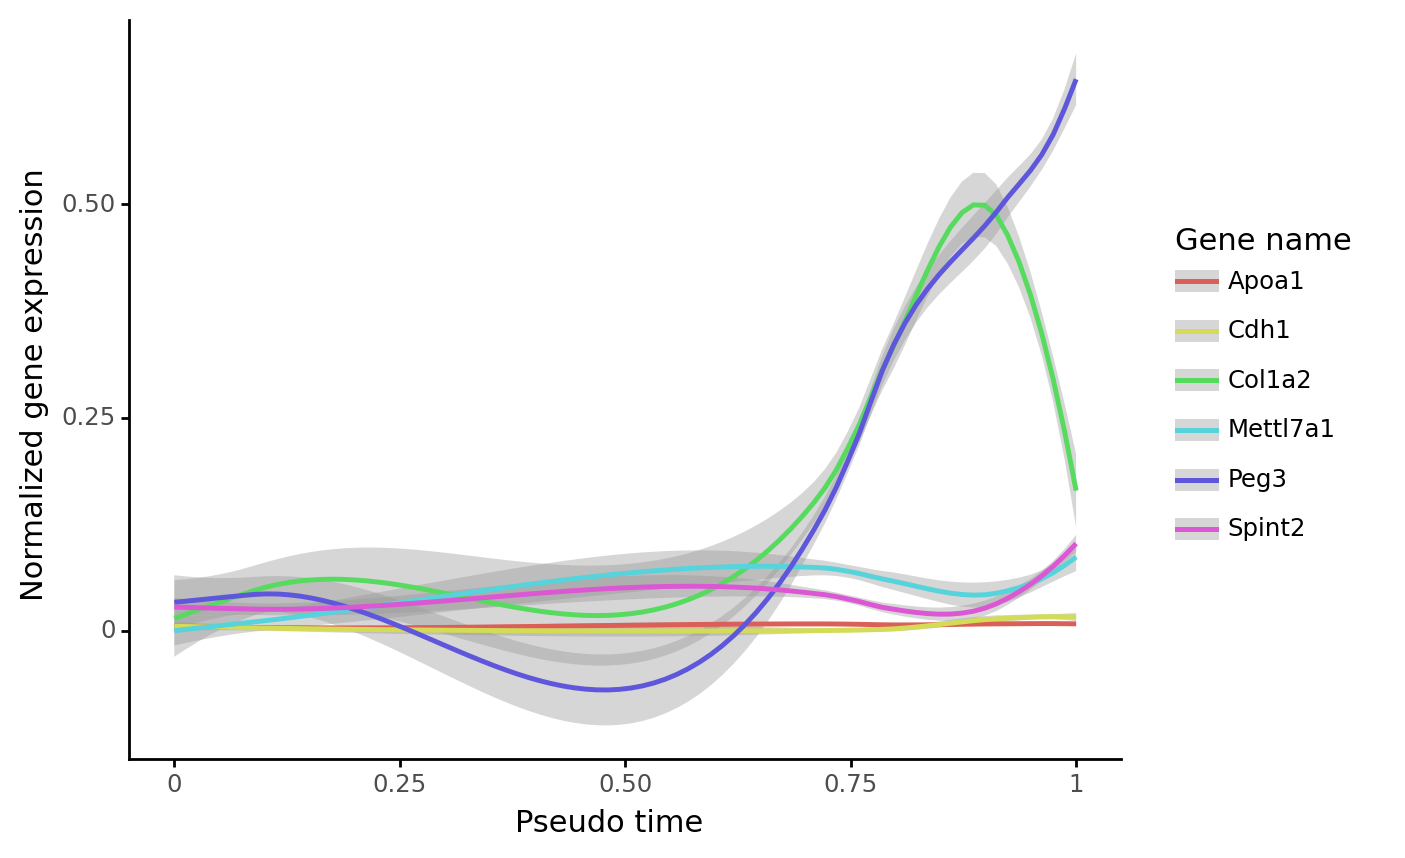

In [25]:
gene_name_list=['Col1a2','Apoa1','Peg3','Spint2','Mettl7a1','Cdh1']
selected_fate='Failed'
adata_selected=cs.pl.gene_expression_dynamics(adata,selected_fate,gene_name_list, traj_threshold=0.1,  
      map_backwards=True, invert_PseudoTime=True, include_target_states=True, compute_new=True, 
    fig_width=3.5, gene_exp_percentile=99, n_neighbors=8, plot_raw_data=False, point_size=2)

Expression dynamics along the reprogramming trajectory:

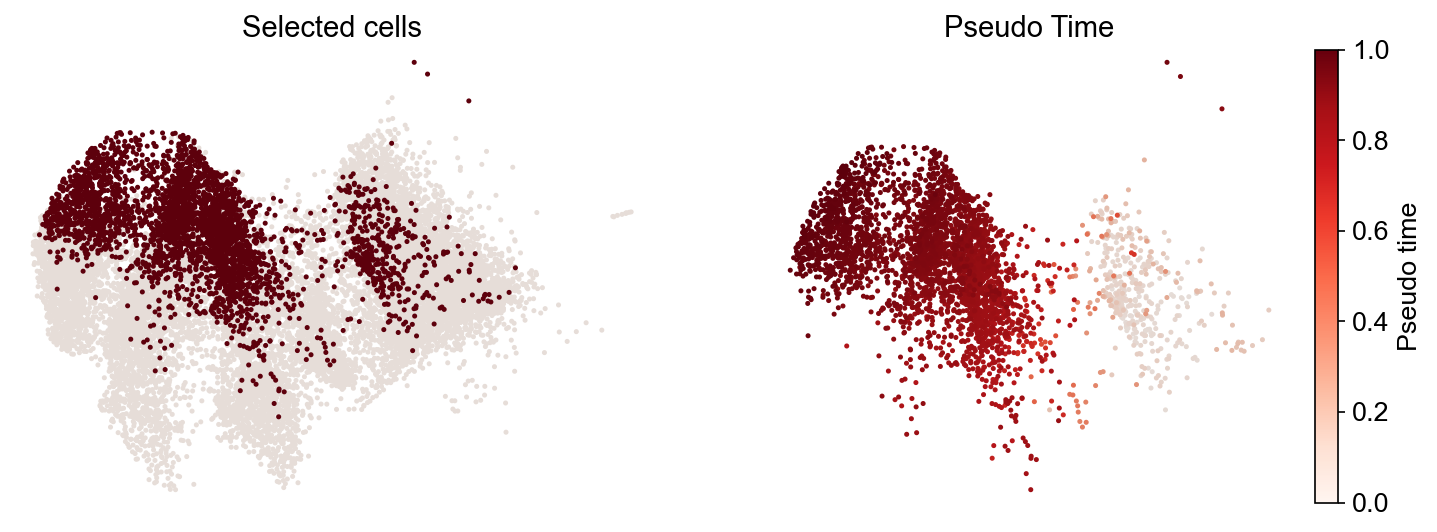

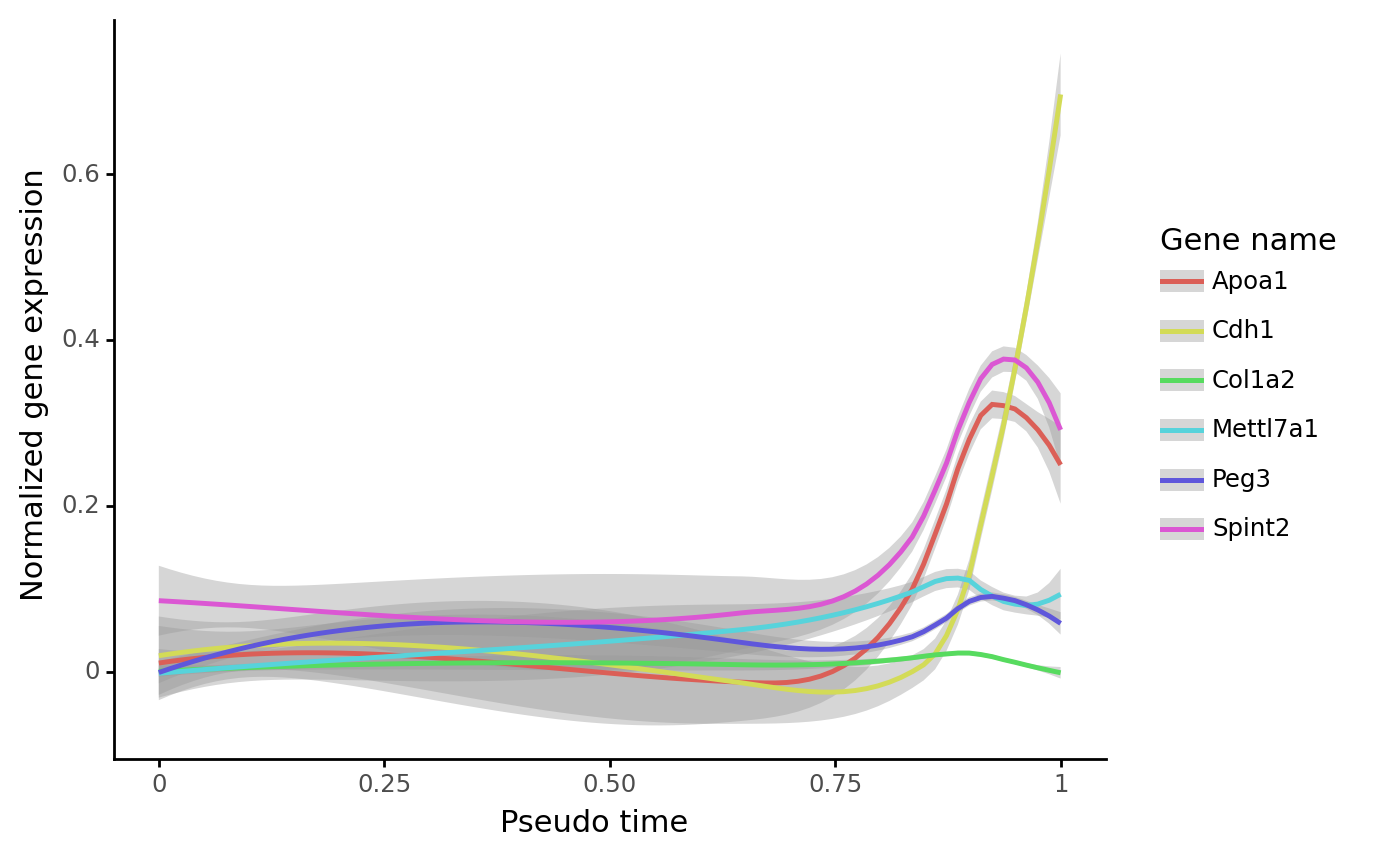

In [26]:
gene_name_list=['Col1a2','Apoa1','Peg3','Spint2','Mettl7a1','Cdh1']
selected_fate='Reprogrammed'
adata_selected=cs.pl.gene_expression_dynamics(adata,selected_fate,gene_name_list, traj_threshold=0.1,  
      map_backwards=True, invert_PseudoTime=True, include_target_states=True, compute_new=True, 
    fig_width=3.5, gene_exp_percentile=99, n_neighbors=8, plot_raw_data=False, point_size=2)

### Transition map from only clonal information
Assume uniform transition within the same clone

Use all clones (naive method)


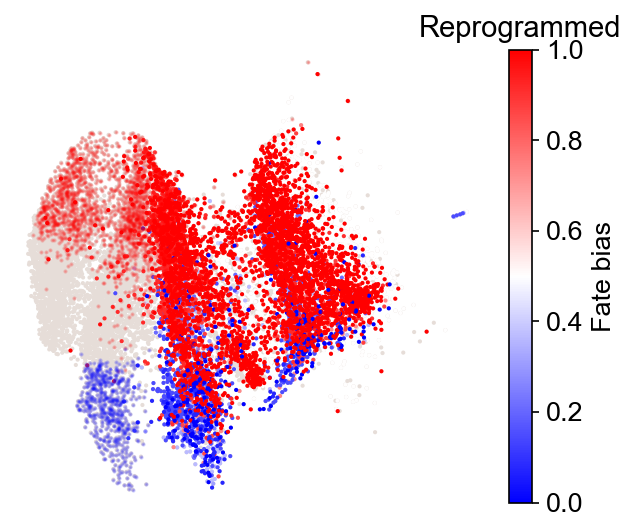

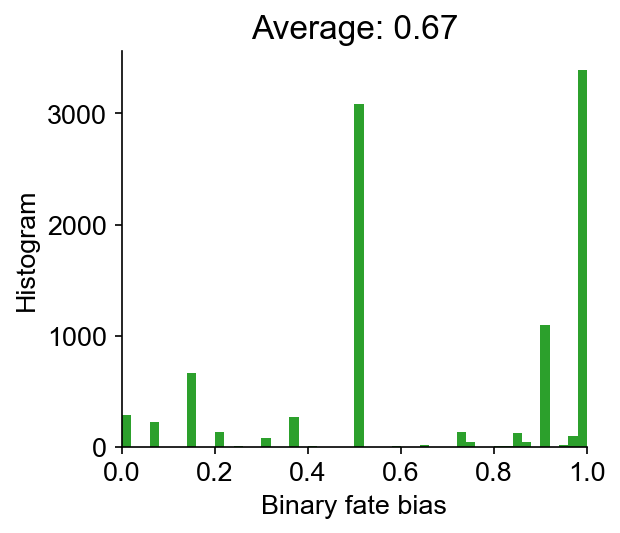

In [27]:
cs.tmap.infer_Tmap_from_clonal_info_alone(adata,method='naive')

cs.pl.fate_bias_from_binary_competition(adata,selected_fates=['Reprogrammed','Failed'],used_map_name='clonal_transition_map',
            selected_time_points=[],plot_target_state=True,map_backwards=True,sum_fate_prob_thresh=0)

## Part II: Infer transition map using clones from the last time point

It takes 12 mins to compute for the first time (excluding the time for computing similarity matrix); and 5 mins later.

In [28]:
initial_time_points=['3','4','5','6','7']
clonal_time_point='8'

adata=cs.tmap.infer_Tmap_from_one_time_clones(adata_orig,initial_time_points,clonal_time_point,
        initialize_method='OT',OT_cost='SPD',smooth_array=[15,10,5],noise_threshold=0.2,use_full_Smatrix=True)

-------------------------------New Start--------------------------------------------------
Current time point: 3
-----------Pre-processing and sub-sampling cells------------
----------------
Step 1: Use OT method for initialization
Compute new shortest path distance matrix
--> Chosen mode is distances
Finishing computing shortest-path distance, used time 51.460700273513794
Compute new custon OT matrix
OT solver: duality_gap
Finishing computing optial transport map, used time 4.4223010540008545
----------------
Step 2: Jointly optimize the transition map and the initial clonal states!
Joint optimization that consider possibility of clonal overlap: v2
--> original clone shape: (6654, 414)
--> After excluding zero-sized clones at t2: (6654, 348)
Sort clones by size (small to large)
Infer the number of initial cells to extract for each clone in advance
--> Inferring early clonal states: current clone id 0
--> Inferring early clonal states: current clone id 100
--> Inferring early clonal st

-------------------------------New Start--------------------------------------------------
Current time point: 6
-----------Pre-processing and sub-sampling cells------------
----------------
Step 1: Use OT method for initialization
Compute new shortest path distance matrix
--> Chosen mode is distances
Finishing computing shortest-path distance, used time 76.91150283813477
Compute new custon OT matrix
OT solver: duality_gap
Finishing computing optial transport map, used time 61.49519991874695
----------------
Step 2: Jointly optimize the transition map and the initial clonal states!
Joint optimization that consider possibility of clonal overlap: v2
--> original clone shape: (9855, 903)
--> After excluding zero-sized clones at t2: (9855, 348)
Sort clones by size (small to large)
Infer the number of initial cells to extract for each clone in advance
--> Inferring early clonal states: current clone id 0
--> Inferring early clonal states: current clone id 100
--> Inferring early clonal stat

In [29]:
cs.hf.check_available_choices(adata)

Available transition maps: ['transition_map', 'OT_transition_map']
Availabel clusters: ['12', '8', '21', 'Failed', '4', '2', '15', '13', '18', '10', '9', '11', '3', '0', '5', '20', '16', '7', '19', '22', 'Reprogrammed']
Availabel time points: ['4', '3', '8', '5', '6', '7']
Clonal time points: ['4', '3', '8', '5', '6', '7']


### Fate map

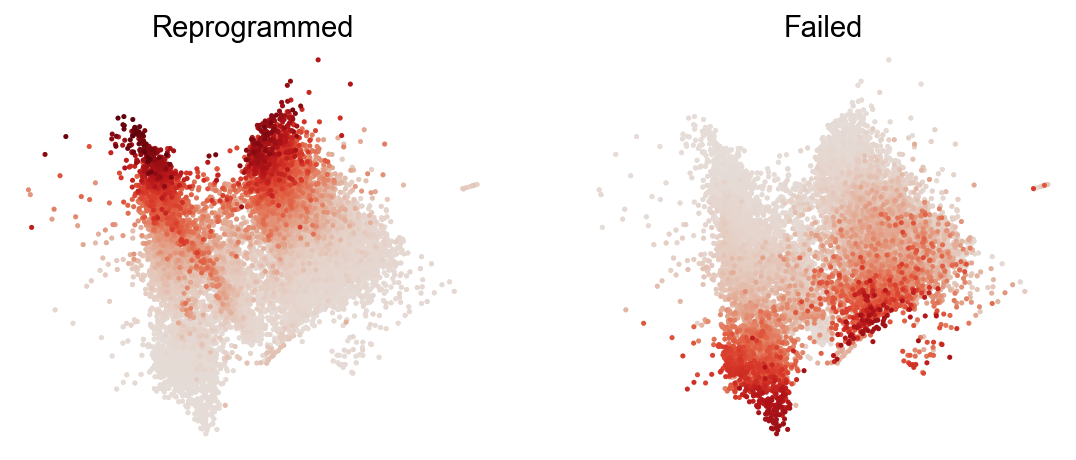

In [30]:
cs.pl.fate_map(adata,selected_fates=['Reprogrammed','Failed'],
               used_map_name='transition_map',map_backwards=True,plot_target_state=False,
               color_bar=False,background=False,auto_color_scale=False,horizontal=True)

### Relative fate bias

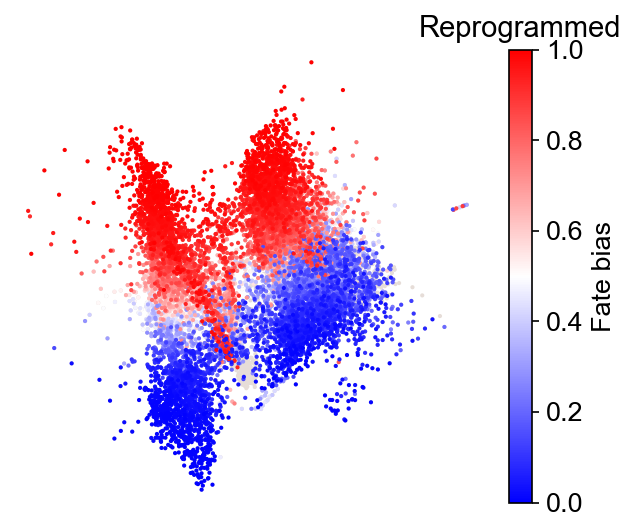

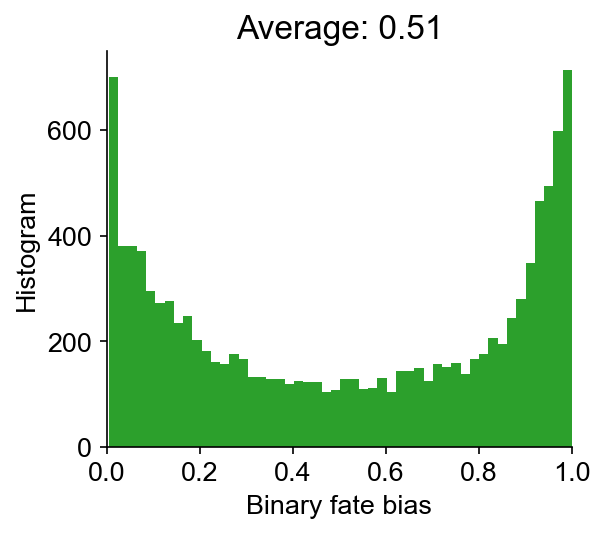

In [31]:
cs.pl.fate_bias_from_binary_competition(adata,selected_fates=['Reprogrammed','Failed'],used_map_name='transition_map',
            selected_time_points=[],plot_target_state=False,map_backwards=True,sum_fate_prob_thresh=0.1)

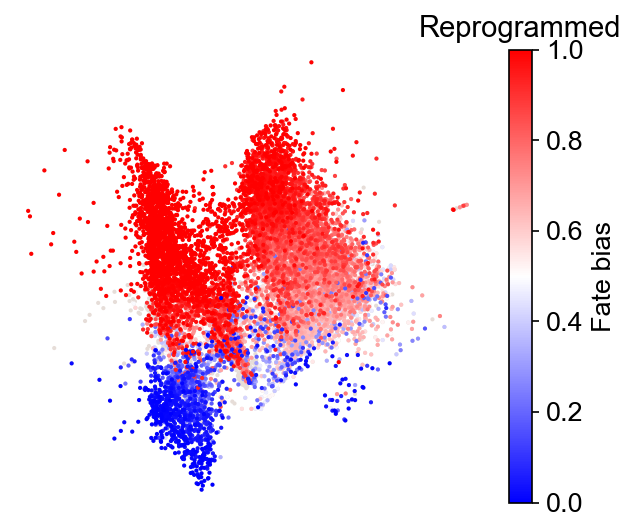

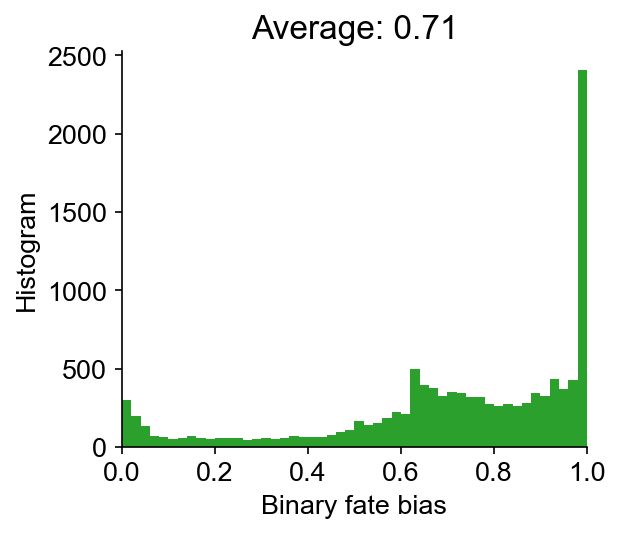

In [32]:
cs.pl.fate_bias_from_binary_competition(adata,selected_fates=['Reprogrammed','Failed'],used_map_name='OT_transition_map',
            selected_time_points=[],plot_target_state=False,map_backwards=True,sum_fate_prob_thresh=0.1)

### Dynamic trajectory inference

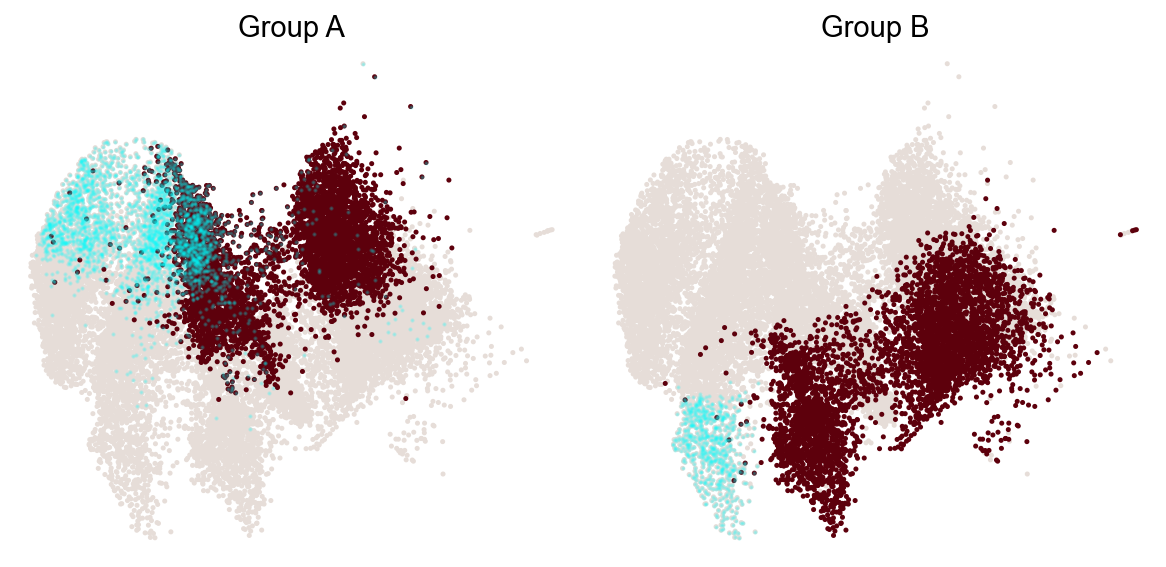

In [33]:
cs.pl.dynamic_trajectory_from_competition_bias(adata, selected_fates=['Reprogrammed','Failed'], 
 used_map_name='transition_map', map_backwards=True, selected_time_points=[],
    bias_threshold=0, sum_fate_prob_thresh=0.2, avoid_target_states=False)


### Gene trend along the dynamic trajectory

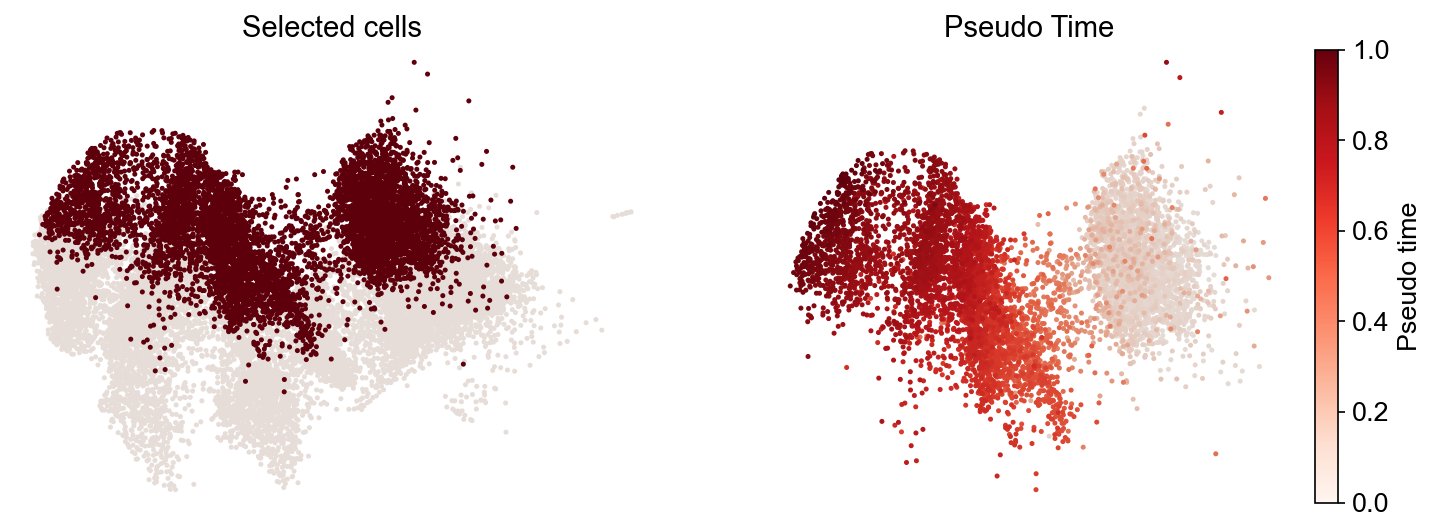

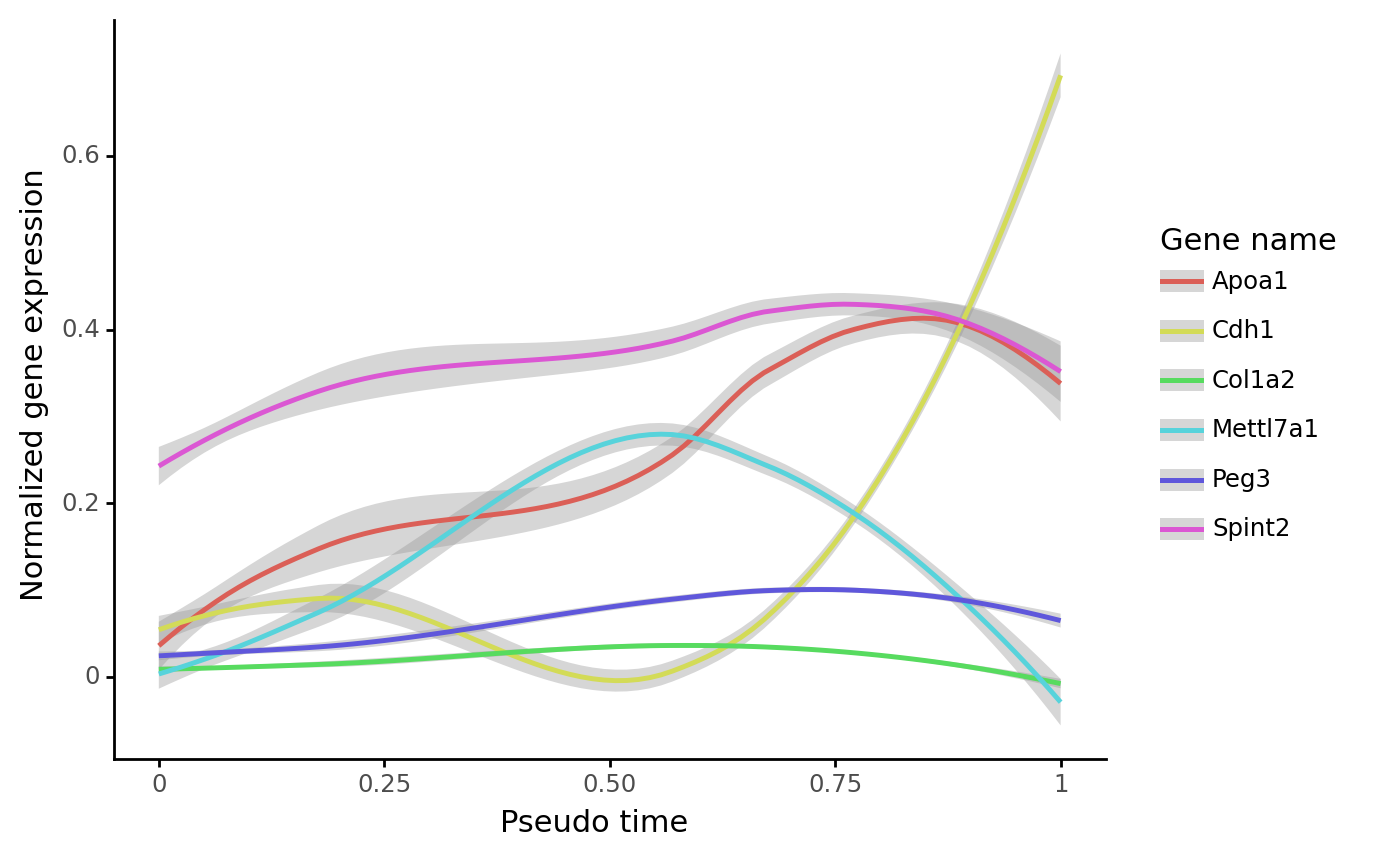

In [34]:
gene_name_list=['Col1a2','Apoa1','Peg3','Spint2','Mettl7a1','Cdh1']
selected_fate='Reprogrammed'
adata_selected=cs.pl.gene_expression_dynamics(adata,selected_fate,gene_name_list, traj_threshold=0.2,  
      map_backwards=True, invert_PseudoTime=False, include_target_states=True)

## Part III: Infer transition map from state information alone

In [35]:
initial_time_points=['6','7']
target_time_point='8'

adata=cs.tmap.infer_Tmap_from_state_info_alone(adata_orig,initial_time_points,target_time_point,
        method='OT',OT_cost='SPD')

-------------------------------New Start--------------------------------------------------
Current time point: 6
-----------Pre-processing and sub-sampling cells------------
----------------
Step 1: Use OT method for initialization
Load pre-computed custon OT matrix
-------------------------------New Start--------------------------------------------------
Current time point: 7
-----------Pre-processing and sub-sampling cells------------
----------------
Step 1: Use OT method for initialization
Load pre-computed custon OT matrix
-----------Total used time: 8.77480673789978 s ------------


In [36]:
cs.hf.check_available_choices(adata)

Available transition maps: ['OT_transition_map']
Availabel clusters: ['4', '12', '9', '11', '3', '7', '19', '0', '15', '22', '5', '13', '8', 'Reprogrammed', '18', '10', '21', '20', 'Failed', '16']
Availabel time points: ['6', '8', '7']
Clonal time points: ['6', '8', '7']


### Fate map

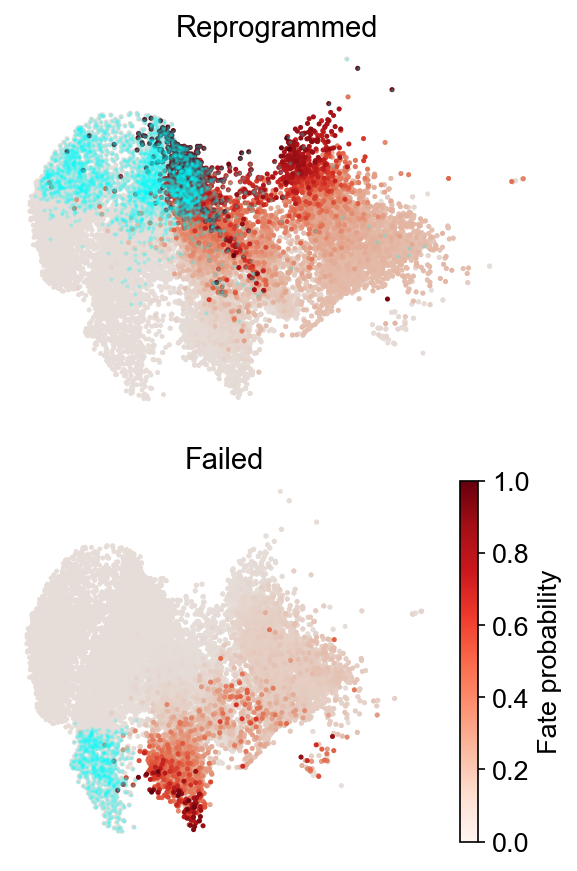

In [37]:
cs.pl.fate_map(adata,selected_fates=['Reprogrammed','Failed'],
               used_map_name='OT_transition_map',map_backwards=True,plot_target_state=True)

### Relative fate bias

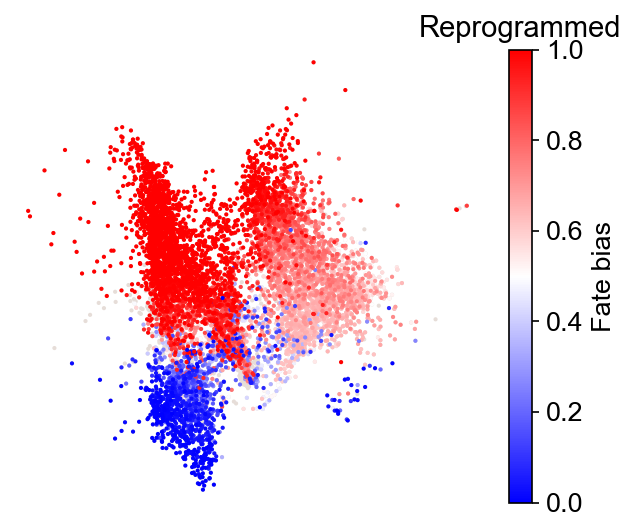

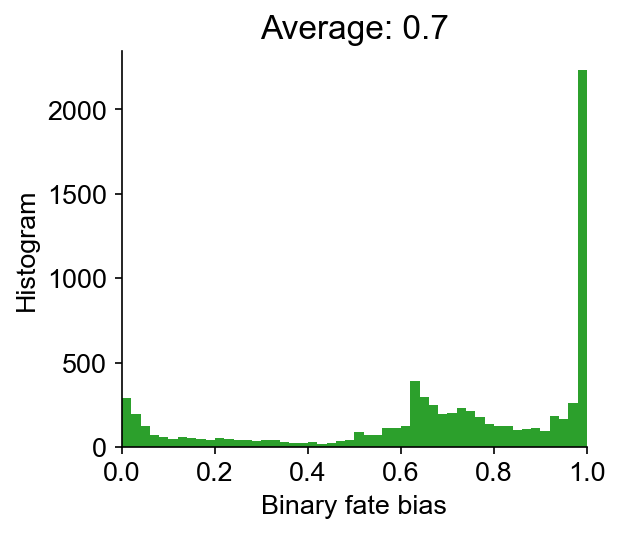

In [38]:
cs.pl.fate_bias_from_binary_competition(adata,selected_fates=['Reprogrammed','Failed'],used_map_name='OT_transition_map',
            selected_time_points=[],plot_target_state=False,map_backwards=True,sum_fate_prob_thresh=0.1)

### Dynamic trajectory inference

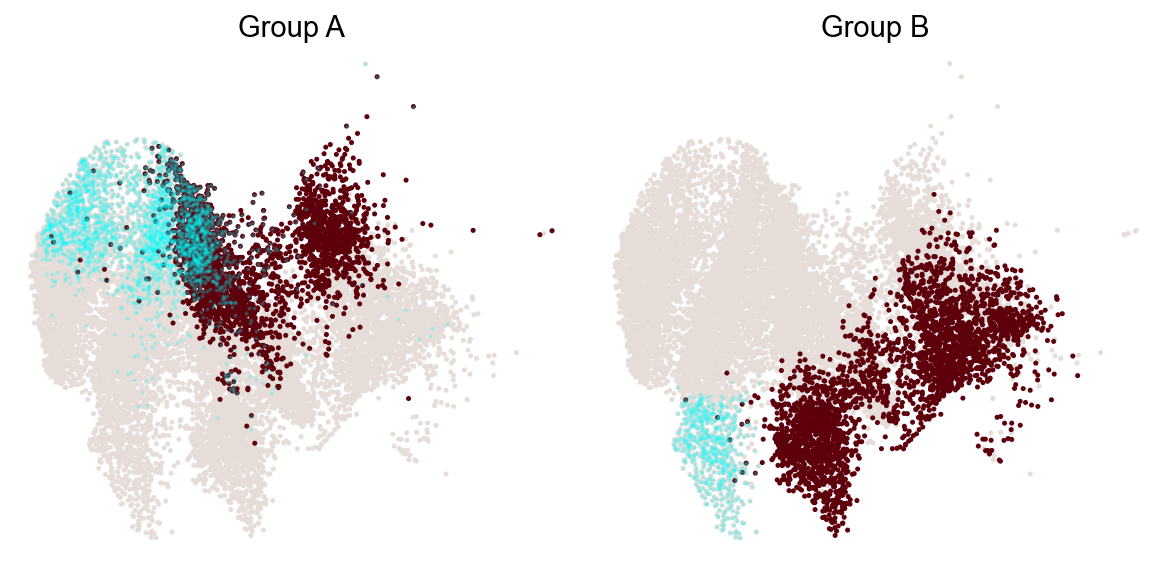

In [39]:
cs.pl.dynamic_trajectory_from_intrinsic_bias(adata, selected_fates=['Reprogrammed','Failed'], 
 used_map_name='OT_transition_map', map_backwards=True, selected_time_points=[],
    bias_threshold_A=0.5, bias_threshold_B=0.5, avoid_target_states=False)


### Gene trend along the dynamic trajectory

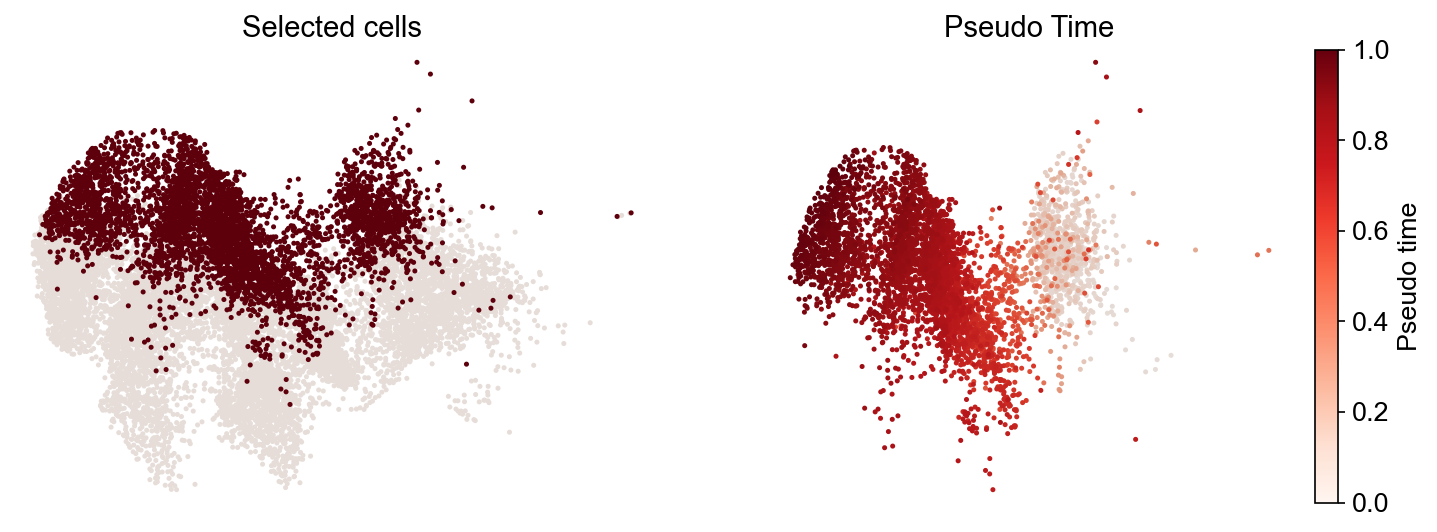

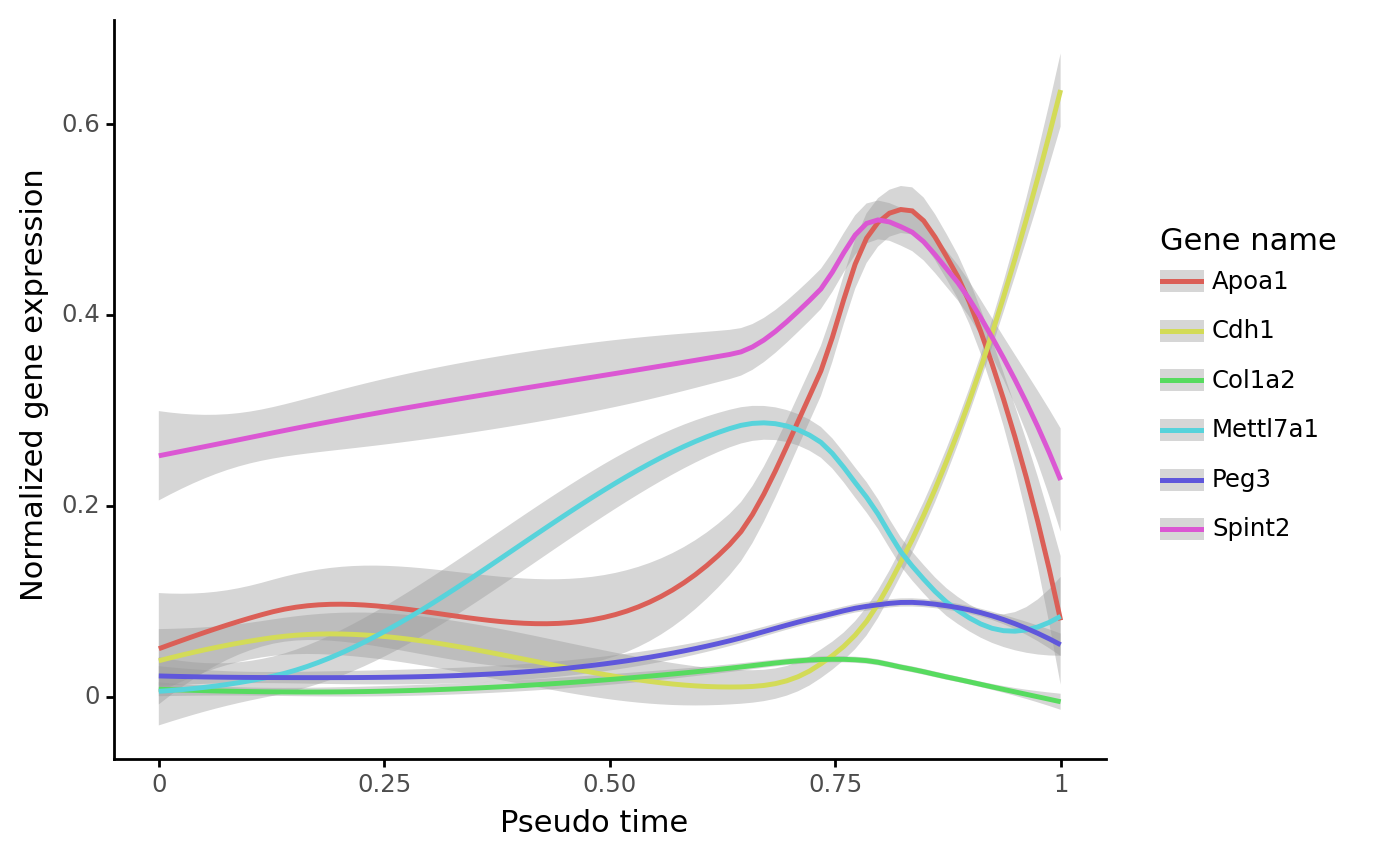

In [40]:
gene_name_list=['Col1a2','Apoa1','Peg3','Spint2','Mettl7a1','Cdh1']
selected_fate='Reprogrammed'
adata_selected=cs.pl.gene_expression_dynamics(adata,selected_fate,gene_name_list, traj_threshold=0.2,  
      map_backwards=True, invert_PseudoTime=True, include_target_states=True)